# Analysis and Results Visualization

This script describes the procedure to request an analysis to the Viking Analytics' MultiViz Analytics Engine (MVG) service.
It shows how to query for results of single-asset or asset-population analyses.
In addition, it presents some examples of how to visualize the results available for the mode identification feature.

In this example, we will describe how to access and manipulate the analysis results directly.
The ["Analysis Classes"](analysis_classes.ipynb) example provides a simplified and unified interface to access these results as a pandas dataframe, along with some basic visualization of the results.

## Preliminaries

This procedure describes all the steps to request an analysis, get analysis results and plot those results using the functions in `plotting`.
Local visualizations functions to create the figures are imported from `plotting`. 

In [1]:
import os
import pandas as pd

# import mvg library with python bindings to mvg-API
from mvg import MVG, plotting

Note that the `TOKEN` is used both for authorization and authentication. Thus, each unique token represents a unique user and each user has their own unique database on the VA vibration service.

**You need to insert your token received from Viking Analytics here:

In [2]:
# Replace by your own Token
VALID_TOKEN = os.environ['TEST_TOKEN']

Instantiate a session object with MVG library.
A session object basically caches the endpoint and the token, to simplify the calls to the MVG library.

In [3]:
ENDPOINT = "https://api.beta.multiviz.com"
session = MVG(ENDPOINT, VALID_TOKEN)

## Asset Analysis

In this example, we will use the sources uploaded by the ["Sources and Measurement"](sources_and_measurements.ipynb) example.
We start by looking if the sources are available in the database.
At least, sources, "u0001" and "u0005", should appear as available.

In [4]:
sources = session.list_sources()

for src in sources:
    s_info = session.get_source(src['source_id'])
    print(f"Source info retrieved:\n{s_info}\n")

Source info retrieved:
{'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris', 'updated': 'YES! I have been updated'}, 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Source info retrieved:
{'source_id': 'u0002', 'meta': {'assetId': 'assetB', 'measPoint': 'mloc01', 'location': 'paris'}, 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Source info retrieved:
{'source_id': 'u0003', 'meta': {'assetId': 'assetC', 'measPoint': 'mloc01', 'location': 'milano'}, 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Source info retrieved:
{'source_id': 'u0004', 'meta': {'assetId': 'assetD', 'measPoint': 'mloc01', 'location': 'milano'}, 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Source info retrieved:
{'source_id': 'u0005', 'meta': {'assetId': 'assetE', 'measPoint': 'mloc01', 'location': 'london'}, 'properties': {'data_class': 'waveform', 'channels': ['acc']}}

Source info retrieved:
{'source_i

During our example, we will utilize sources, "u0001" and "u0005", which were previously uploaded to our database.

In [5]:
SOURCE_IDS = ["u0001", "u0005"]
SOURCE_IDS

['u0001', 'u0005']

The Viking Analytics Vibration service has several features available.
We list the available features along with the version of each of them in the following way:

In [6]:
available_features = session.supported_features()
available_features

{'RMS': '1.0.0',
 'ModeId': '0.1.1',
 'BlackSheep': '1.0.0',
 'KPIDemo': '1.0.0',
 'LabelPropagation': '0.1.0'}

Once the source and measurements had been uploaded in the database, we can request an analysis to the VA Vibration service.
When we request an analysis, we need to say which source is to be used in the analysis and the feature to be applied.

The requested analysis will return a dictionary object with two elements.
The first element is a `"request_id"` that can be used to retrieve the results after.
The second element is `"request_status"` that provides the status right after placing the analysis request. 

Here, we will request the "KPIDemo" feature from our source "u0001".

In [7]:
SOURCE_ID = SOURCE_IDS[0]
KPI_u0001 = session.request_analysis(SOURCE_ID, 'KPIDemo')
KPI_u0001 

{'request_id': '89b8f004c976ff8991f476be33c198d1', 'request_status': 'queued'}

Now, we proceed to request the "ModeId" feature for the same source.

In [8]:
ModeId_u0001 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0001 

{'request_id': '6a3635aef7b01e858c3da0d546c1e5eb', 'request_status': 'queued'}

Before we are able to get the analysis results, we need to wait until those analyses are successfully completed.

We can query for the status of our requested analyses.
The possible status are:
- Queued: The analysis has not started in the remote server and it is in the queue to begin.
- Ongoing: The analysis is been processed at this time.
- Failed: The analysis is complete and failed to produce a result.
- Successful: The analysis is complete and it produced a successful result.

In [9]:
REQUEST_IDS_u0001 = [KPI_u0001['request_id'], ModeId_u0001['request_id']]
status = session.get_analysis_status(REQUEST_IDS_u0001[0])
print(f"KPI Analysis: {status}")
status = session.get_analysis_status(REQUEST_IDS_u0001[1])
print(f"ModeId Analysis: {status}")

KPI Analysis: successful
ModeId Analysis: successful


The similar procedure is repeated to request the "RMS" and "ModeId" for our source "u0005".

In [10]:
SOURCE_ID = SOURCE_IDS[1]
KPI_u0005 = session.request_analysis(SOURCE_ID, 'KPIDemo')
KPI_u0005

{'request_id': '1247756254716ed33bac1c470aa09eb1', 'request_status': 'queued'}

In [11]:
SOURCE_ID = SOURCE_IDS[1]
ModeId_u0005 = session.request_analysis(SOURCE_ID, 'ModeId')
ModeId_u0005

{'request_id': 'de4474095fc5b53c9a6059ce2c685366', 'request_status': 'queued'}

Also, we check the status of our analysis for source "u0005" to confirm they had been completed successfully.

In [12]:
REQUEST_IDS_u0005 = [KPI_u0005['request_id'], ModeId_u0005['request_id']]
status = session.get_analysis_status(REQUEST_IDS_u0005[0])
print(f"KPI Analysis: {status}")
status = session.get_analysis_status(REQUEST_IDS_u0005[1])
print(f"ModeId Analysis: {status}")

KPI Analysis: successful
ModeId Analysis: successful


## Visualization

Once the analysis is complete, one get the results by calling the corresponding "request_id" for each analysis.

First, let's check all existing "request_id" in the database for each source and feature.

In [13]:
REQUEST_IDS_RMS = [session.list_analyses(SOURCE_IDS[0], "KPIDemo"), session.list_analyses(SOURCE_IDS[1], "KPIDemo")]
print(f"The KPI analysis of {SOURCE_IDS[0]} has request_id {REQUEST_IDS_RMS[0]}.")
print(f"The KPI analysis of {SOURCE_IDS[1]} has request_id {REQUEST_IDS_RMS[1]}.")
REQUEST_IDS_MODEID = [session.list_analyses(SOURCE_IDS[0], "ModeId"), session.list_analyses(SOURCE_IDS[1], "ModeId")]
print(f"The ModeId analysis of {SOURCE_IDS[0]} has request_id {REQUEST_IDS_MODEID[0]}.")
print(f"The ModeId analysis of {SOURCE_IDS[1]} has request_id {REQUEST_IDS_MODEID[1]}.")

The KPI analysis of u0001 has request_id ['1e87505977a4a4f0ebef1e47fe2e07de', '6dad3d5f0088688dc255e568f490755f', '89b8f004c976ff8991f476be33c198d1'].
The KPI analysis of u0005 has request_id ['1247756254716ed33bac1c470aa09eb1'].
The ModeId analysis of u0001 has request_id ['57b816d91decda67355da0ad160f0016', '535be882dd271d03c26bef8257ae03ec', 'e0ee3ad6935947f70a9d455f37da4c48', 'e176f4928372a627e743222eb2de0690', '25bdf3a393c5c166ae230ef98911606c', '9cced936d101c436eb32e7f8dc379796', 'd34f7e8f0a5b01a8471f1a5df23e1923', 'a089f212b2eda4eb79fc569b00c74659', 'ba1202a3c210c9e388a980913cda3640', '2c2bfebdbda7f75000f3c6e5128d3efc', '7b3aae14f266697da1d140410627a6b6', 'd132fb68a652104c678acdd6fe514de5', '30f136353e213b0d4e090f8a7724f65a', 'b9d566e83b71e8c21aa927e15148978c', 'b436d607166ccc8c183305105e198f48', 'fc66d902840d7eb3fdd1d1147dacf417', '7b688623d9e6cf5ea63aaf2ce0318962', 'c1a1dc59c94e9a6a7f810cf802cb9d78', '011781f6412daaf48640fbc5bd85a0e4', '8270d75575d4c53b5520a04d59a9475b', '1f47

The following step is to retrieve the results by calling each one of the "request_id".

The output of the `"get_analysis_results"` function is a dictionary.
We show the keys of one those dictionaries.
The keys are the same for all features.

In [14]:
session.wait_for_analyses(REQUEST_IDS_u0001 + REQUEST_IDS_u0005)

kpi_output1 = session.get_analysis_results(request_id=REQUEST_IDS_u0001[0])
mode_output1 = session.get_analysis_results(request_id=REQUEST_IDS_u0001[1])
kpi_output5 = session.get_analysis_results(request_id=REQUEST_IDS_u0005[0])
mode_output5 = session.get_analysis_results(request_id=REQUEST_IDS_u0005[1])

kpi_output1.keys()

dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

Each dictionary contains seven key elements.
These elements are:
- `"status"` indicates if the analysis was successful.
- `"request_id"` is the identifier of the requested analysis.
- `"feature"` is the name of the request feature.
- `"results"` includes the numeric results.
- `"inputs"` includes the input information for the request analysis.
- `"error_info"` includes the error information in case the analysis fails and it is empty if the analysis is successful.
- `"debug_info"` includes debugging (log) information related to the failed analysis.


The `"results"` of the "KPIDemo" feature is a list per channel defined in the source. Each channel is formed by eight lists.
These lists are:
- rms: rms value for each measurement.
- peak: peak value for each measurement.
- peak2peak: peak-to-peak value for each measurement.
- variance: variance value for each measurement.
- crest_factor: crest factor value for each measurement.
- utilization: boolean indicating whether the measurement was used for the rms calculation.
- dc_component: DC component value for each measurement.
- timestamps: epoch (in seconds for this example) of the measurements.


These lists can be converted into a dataframe for ease of manipulation.
In this example, we will show how to access the dictionary results information and convert it into a Pandas dataframe.
Please check the ["Analysis Classes"](analysis_classes.ipynb) example for directly getting a results Pandas dataframe.
In addition, the "timestamp" column is converted to a timestamp object in a column called "Date".

In [15]:
df_kpi1 = pd.DataFrame(kpi_output1["results"]["acc"])
df_kpi1["timestamps"] = kpi_output1["results"]['timestamps']
df_kpi1['Date'] = pd.to_datetime(df_kpi1['timestamps'], unit="s")
df_kpi1.head()

,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps,Date
0,0.647123,2.691750,5.367004,0.418769,4.159563,1,-0.140420,1570273260,2019-10-05 11:01:00
1,0.646619,2.715251,5.414856,0.418116,4.199152,1,-0.140239,1570359660,2019-10-06 11:01:00
2,0.646873,2.685147,5.351562,0.418445,4.150966,1,-0.140347,1570446060,2019-10-07 11:01:00
3,0.646643,2.726605,5.395325,0.418147,4.216556,1,-0.140423,1570532460,2019-10-08 11:01:00
4,0.646717,2.697001,5.310974,0.418243,4.170294,1,-0.140055,1570618860,2019-10-09 11:01:00


The `"results"` of the "ModeId" feature are four lists and one dictionary:
- The first list is the measurement epoch in the same unit as the measurement was uploaded, which is seconds for this example.
- The second list corresponds to the mode label given to the timestamp.
- The third list is a boolean to indicate the uncertainty of label.
- The fourth list corresponds to the mode probability of each mode label.

The dictionary, called 'model_info', contains the "Emerging modes" results.

"Emerging modes" is an additional output of the analysis results that describes the first appearance of each one of the identified modes.

We pass all the lists to a dataframe for ease of manipulation.
Similarly to the RMS feature, we will show how to access the dictionary results information and convert it into a Pandas dataframe.
Please check the ["Analysis Classes"](analysis_classes.ipynb) example for directly getting a results Pandas dataframe.
In addition, the "timestamp" column is converted to a timestamp object in a column called "Date".

In [16]:
mode_all1 = mode_output1["results"].copy()
mode_probabilities1 = mode_all1.pop("mode_probabilities")
mode_emerging1 = mode_all1.pop("mode_info")

# Conversion to dataframe of the full mode labels table
df_mode1 = pd.DataFrame(mode_all1)
df_mode1['Date'] = pd.to_datetime(df_mode1['timestamps'], unit="s")
df_mode1.head()

,timestamps,labels,uncertain,mode_probability,Date
0,1570273260,2,False,0.955361,2019-10-05 11:01:00
1,1570359660,2,False,0.945646,2019-10-06 11:01:00
2,1570446060,2,False,0.994171,2019-10-07 11:01:00
3,1570532460,2,False,0.934523,2019-10-08 11:01:00
4,1570618860,2,False,0.904197,2019-10-09 11:01:00


In [17]:
# Conversion to dataframe of the emerging modes table
df_emerging1 = pd.DataFrame(mode_emerging1)
df_emerging1['emerging_Date'] = pd.to_datetime(df_emerging1['emerging_time'], unit="s")
df_emerging1.head()

,modes,emerging_time,max_prob_time,max_probability,emerging_Date
0,2,1570273260,1570446060,0.994171,2019-10-05 11:01:00
1,1,1571655660,1571742060,0.997687,2019-10-21 11:01:00
2,0,1572350460,1573041660,0.999065,2019-10-29 12:01:00


For the purpose of demonstration of our visualization functions, we will merge the dataframes of the "RMS" results and the "ModeId" results into a single dataframe.

In [18]:
df_u0001 =  pd.merge_asof(df_kpi1, df_mode1, on="timestamps", by="Date")
df_u0001.head()

,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps,Date,labels,uncertain,mode_probability
0,0.647123,2.691750,5.367004,0.418769,4.159563,1,-0.140420,1570273260,2019-10-05 11:01:00,2,False,0.955361
1,0.646619,2.715251,5.414856,0.418116,4.199152,1,-0.140239,1570359660,2019-10-06 11:01:00,2,False,0.945646
2,0.646873,2.685147,5.351562,0.418445,4.150966,1,-0.140347,1570446060,2019-10-07 11:01:00,2,False,0.994171
3,0.646643,2.726605,5.395325,0.418147,4.216556,1,-0.140423,1570532460,2019-10-08 11:01:00,2,False,0.934523
4,0.646717,2.697001,5.310974,0.418243,4.170294,1,-0.140055,1570618860,2019-10-09 11:01:00,2,False,0.904197


We repeat the same procedure of converting the results to a dataframe for source "u0005".

In [19]:
#RMS
df_rms5 = pd.DataFrame(kpi_output5["results"]["acc"])
df_rms5["timestamps"] = kpi_output5["results"]['timestamps']
df_rms5['Date'] = pd.to_datetime(df_rms5['timestamps'], unit="s")
#MODE_ID (full)
mode_all5 = mode_output5["results"].copy()
mode_probabilities5 = mode_all5.pop("mode_probabilities")
mode_emerging5 = mode_all5.pop("mode_info")
df_mode5 = pd.DataFrame(mode_all5)
df_mode5['Date'] = pd.to_datetime(df_mode5['timestamps'], unit="s")
#Merging dataframes
df_u0005 = pd.merge_asof(df_rms5, df_mode5, on="timestamps", by="Date")
df_u0005.head()

,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps,Date,labels,uncertain,mode_probability
0,0.646887,2.753406,5.352417,0.418462,4.256397,1,-0.140491,1570186860,2019-10-04 11:01:00,1,False,0.941903
1,0.646963,2.784282,5.446289,0.418562,4.303615,1,-0.140056,1570273260,2019-10-05 11:01:00,1,False,0.829873
2,0.646905,2.767685,5.388000,0.418485,4.278352,1,-0.140244,1570359660,2019-10-06 11:01:00,1,False,0.934453
3,0.647395,2.838854,5.481140,0.419120,4.385044,1,-0.140124,1570446060,2019-10-07 11:01:00,1,False,0.962266
4,0.647057,2.748442,5.371582,0.418683,4.247603,1,-0.140165,1570532460,2019-10-08 11:01:00,1,False,0.950216


We can call the individual boxplot for one source and display the boxplot of the "RMS" for each one of the operating modes.
Here, we use results for source "u0001".

/home/runner/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


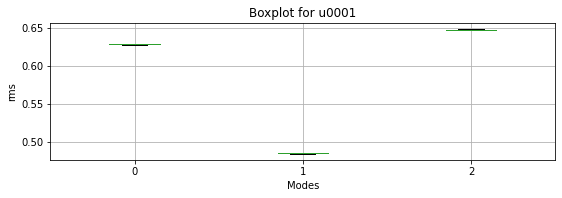

In [20]:
image_boxplot = plotting.modes_boxplot(df_u0001, "rms", SOURCE_IDS[0])

We create a list with all the sources dataframes for the "ModeId" feature and display the "RMS" boxplot across the different modes.

/home/runner/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/home/runner/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


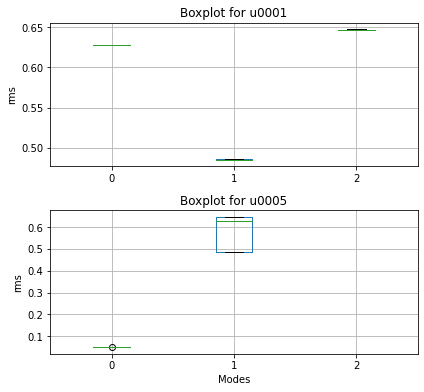

In [21]:
plotting.modes_group_boxplot([df_u0001, df_u0005], "rms", SOURCE_IDS)

We call the display over time of an individual source and identify all its operating modes.
We define the parameter "timeunit" given that the default unit in the function is milliseconds and the epochs in our data is seconds.

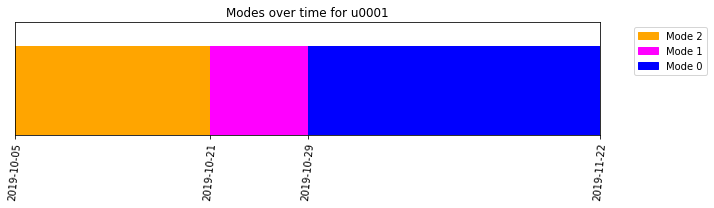

In [22]:
image_modes = plotting.modes_over_time(df_u0001, SOURCE_IDS[0], timeunit="s")

Uncertain areas appear as a gray rectangle above the corresponding periods in the modes plot.
If there are not uncertain areas, the space is white.

We create a list with all the sources dataframes and display the modes over time for all.

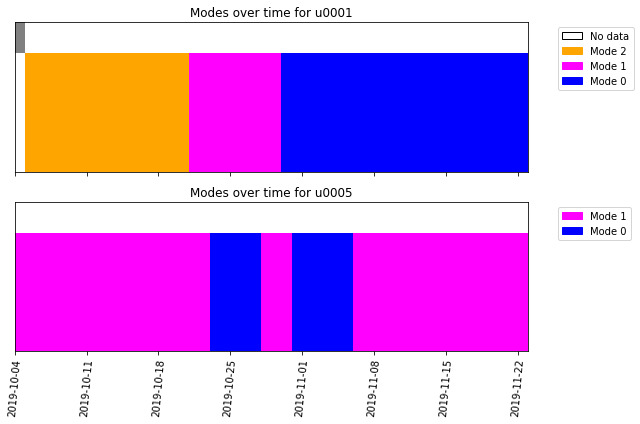

In [23]:
plotting.modes_over_time_group([df_u0001, df_u0005], SOURCE_IDS, timeunit="s")

## Population Analysis

Another feature is "BlackSheep", which targets a group of assets and aims to identify the atypical assets within a population.  

During our example, we will utilize all sources previously uploaded to our database.

In [24]:
SOURCE_ID_ALL = ["u0001", "u0002", "u0003", "u0004", "u0005", "u0006"]
SOURCE_ID_ALL

['u0001', 'u0002', 'u0003', 'u0004', 'u0005', 'u0006']

Similar to single asset feature, the requested population analysis will return a dictionary object with two elements.
The first element is a `"request_id"` that can be used to retrieve the results after.
The second element is `"request_status"` that provides the status right after placing the analysis request. 

Here, we will request the "BlackSheep" feature for all our sources.
In addition, we show how to pass additional parameters into the analysis request.
When we want to pass an additional parameter request, this needs to be in the form of a dictionary.
In this particular analysis, we had relaxed the `"atypical_threshold"` parameter from the default value of 0.05 to 0.10 to discover a larger number of assets as atypical.

In [25]:
params = {"atypical_threshold": 0.1}
BS_ALL = session.request_population_analysis(SOURCE_ID_ALL, 'BlackSheep', parameters = params)
BS_ALL

{'request_id': 'c7d72653de4c1af2cb5b965f70ccad1c', 'request_status': 'queued'}

Similarly, we can query for the status of our requested analysis, where the different status options remain the same.

In [26]:
REQUEST_ID_ALL = BS_ALL['request_id']
status = session.get_analysis_status(REQUEST_ID_ALL)
print(f"BlackSheep Analysis: {status}")

BlackSheep Analysis: successful


The next step is to retrieve the results by calling the "request_id".

The output of the `"get_analysis_results"` function is similar to single asset features.
These seven elements are:
- `"status"` indicates if the analysis was successful.
- `"request_id"` is the identifier of the requested analysis.
- `"feature"` is the name of the request feature.
- `"results"` includes the numeric results.
- `"inputs"` includes the input information for the request analysis.
- `"error_info"` includes the error information in case the analysis fails and it is empty if the analysis is successful.
- `"debug_info"` includes debugging (log) information related to the failed analysis.

In [27]:
session.wait_for_analyses([REQUEST_ID_ALL])
blacksheep_table = session.get_analysis_results(request_id=REQUEST_ID_ALL)
blacksheep_table.keys()

dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

The `"results"` of the "BlackSheep" indicates the atypical assets.
`"results"` is a dictionary with a key element labelled `"atypical_assets"`.
`"atypical_assets"` is a list and the length of the list indicates the number of atypical assets.
Each element on this list is a dictionary.
The dictionary includes the source_id of the atypical assets, a list with all the measurement timestamps and the corresponding list with a boolean indicating whether the measurement is atypical.

Here, we show the number of atypical assets and the atypical order of these assets.

In [28]:
atypical_output = blacksheep_table["results"]
atypical = atypical_output["atypical_assets"]

print(f"There is a total of {len(atypical)} atypical assets in this analysis.")

There is a total of 2 atypical assets in this analysis.


In [29]:
atypical1 = atypical[0]
atypical2 = atypical[1]
print(f"The 1st blacksheep is {atypical1['source_id']}")
print(f"The 2nd blacksheep is {atypical2['source_id']}")

The 1st blacksheep is u0004
The 2nd blacksheep is u0002


Please check the ["Analysis Classes"](analysis_classes.ipynb) example for some of the visualization options of the blacksheep results.
